# HW_1_Javier_Gilabert_Sabater
## Análisis Predictivo

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Read Data
df = pd.read_csv('aapl_ok.csv',sep=';')
df['fecha'] = pd.to_datetime(df['fecha'],format="%m/%d/%Y")
df['Ingresos'] = df['Ingresos'].str.replace(',', '.').astype(float)
df = df.set_index('fecha')
df.head()

,Trimeste,Ingresos
fecha,,
1989-12-29,Q1 1990,1493.4
1990-03-30,Q2 1990,1346.2
1990-06-29,Q3 1990,1364.8
1990-09-28,Q4 1990,1354.1
1990-12-28,Q1 1991,1675.5


In [14]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [15]:
y_train, y_test = temporal_train_test_split(y = df['Ingresos'].astype('float64').to_period('Q'), test_size=8)

# ETS

In [16]:
from sktime.forecasting.ets import AutoETS

In [17]:
ets_model = AutoETS(auto=True, sp=4, n_jobs=-1)
ets_model.fit(y_train)
print(ets_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood                -968.025
Date:                Mon, 09 Oct 2023   AIC                           1956.050
Time:                        11:56:21   BIC                           1983.841
Sample:                    12-31-1989   HQIC                          1967.335
                         - 06-30-2019   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4225      0.055      7.739      0.000       0.316       0.530
smoothing_trend        0.1685      0.034      4.890      0.000       0.101       0.236
smoothing_seasonal  

In [18]:
from sktime.utils.plotting import plot_series

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

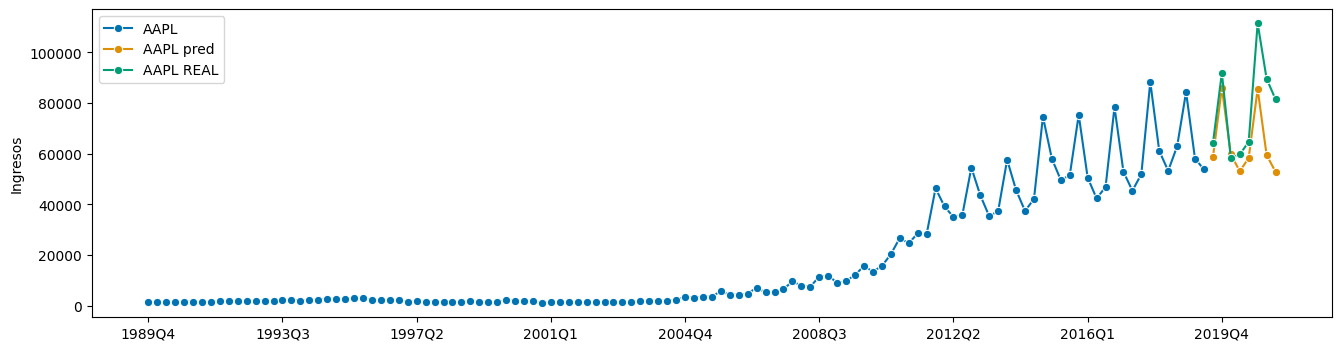

In [19]:
horizon = np.arange(1, 9)
ets_prediction = ets_model.predict(horizon)
ets_intervals = ets_model.predict_interval(horizon, coverage=0.9)
plot_series(y_train, ets_prediction, y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

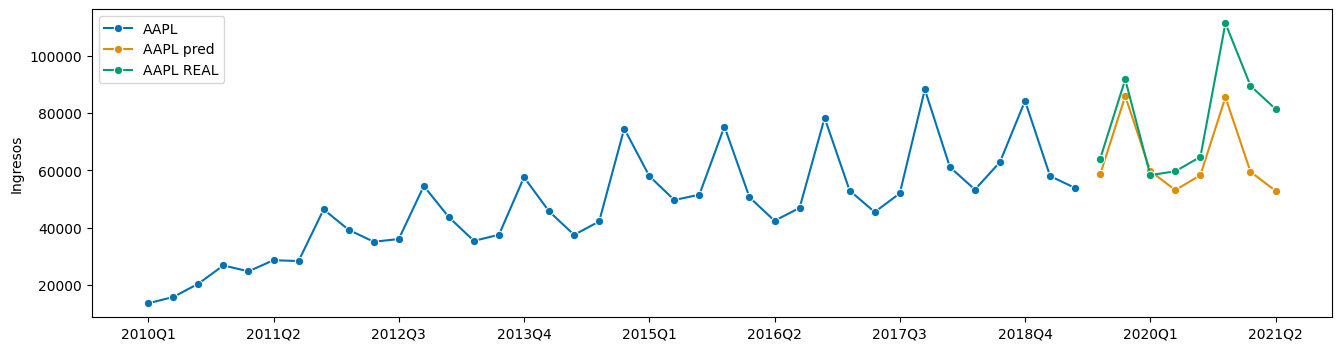

In [20]:
plot_series(y_train['2010':], ets_prediction, y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])

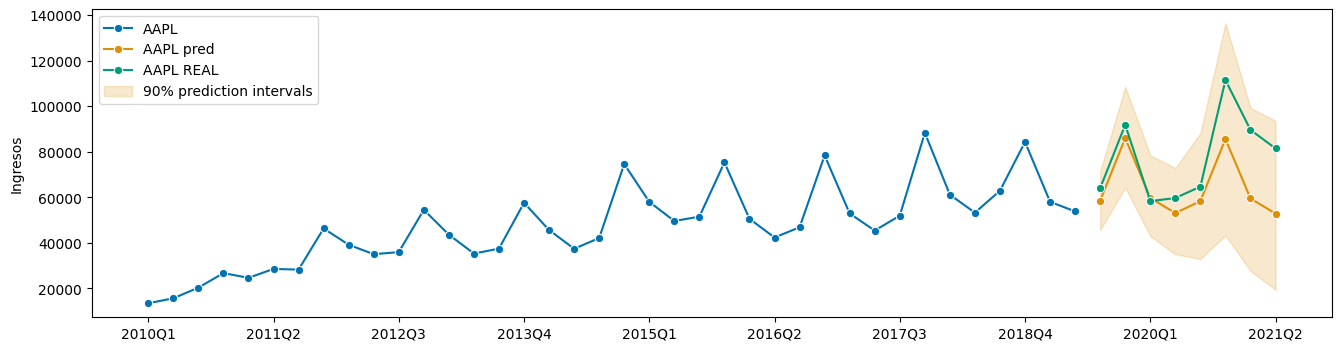

In [21]:
fig, ax = plot_series(y_train['2010':], ets_prediction, y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    ets_intervals[('Ingresos', 0.9, 'lower')],
    ets_intervals[('Ingresos', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')


In [22]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, ets_prediction[0:8])

0.16273953082780607

In [23]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, ets_prediction[0:8])

317747115.49760485

In [24]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, ets_prediction[0:8])

17825.462560550983

# ARIMA

In [25]:
from sktime.transformations.series.boxcox import LogTransformer

Text(0.5, 1.0, 'Ingresos de Apple Con Transformación Logaritmica')

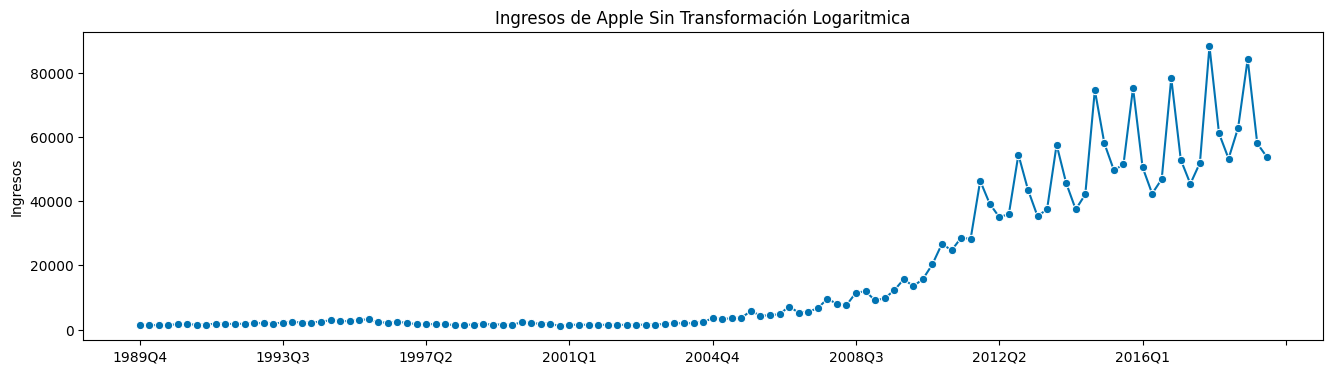

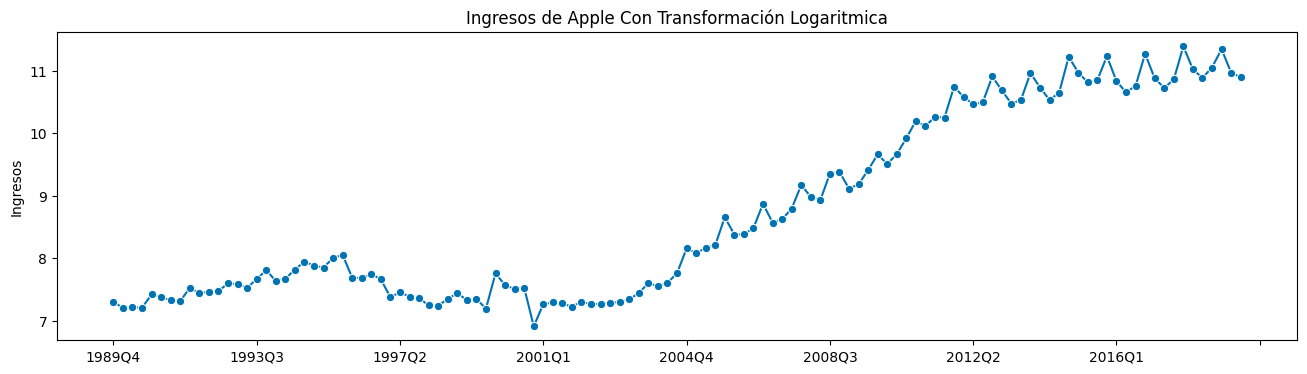

In [26]:
transformer = LogTransformer()
transformer = transformer.fit(y_train)
y_train_log = transformer.transform(y_train)
y_test_log = transformer.transform(y_test)


fig, ax =plot_series(y_train)
ax.set_title('Ingresos de Apple Sin Transformación Logaritmica')
fig, ax =plot_series(y_train_log)
ax.set_title('Ingresos de Apple Con Transformación Logaritmica')

In [27]:
# Autocorrelation Fuction Package
from sktime.utils.plotting import plot_correlations

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Ingresos'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

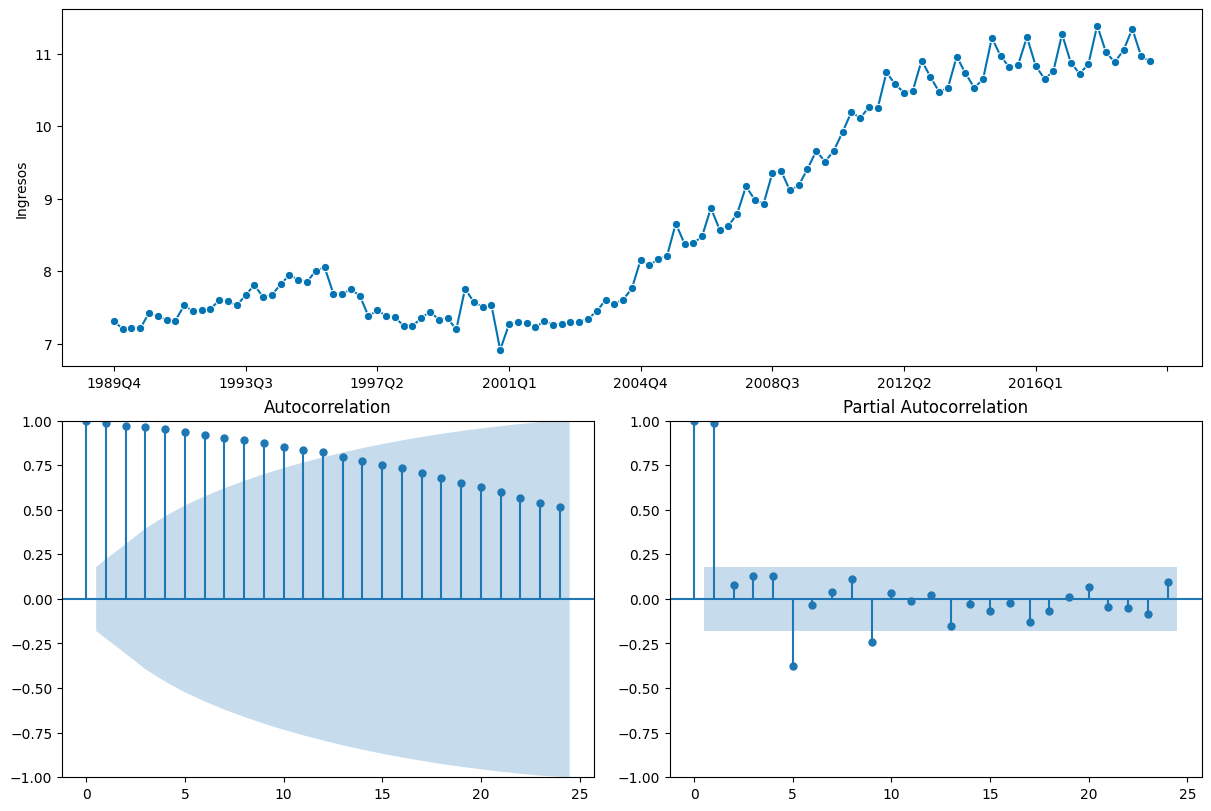

In [28]:
# Autocorrelation Fuction Original Time Series
plot_correlations(y_train_log)

In [29]:
# Difference Fuction Package
from sktime.transformations.series.difference import Differencer

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Ingresos'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

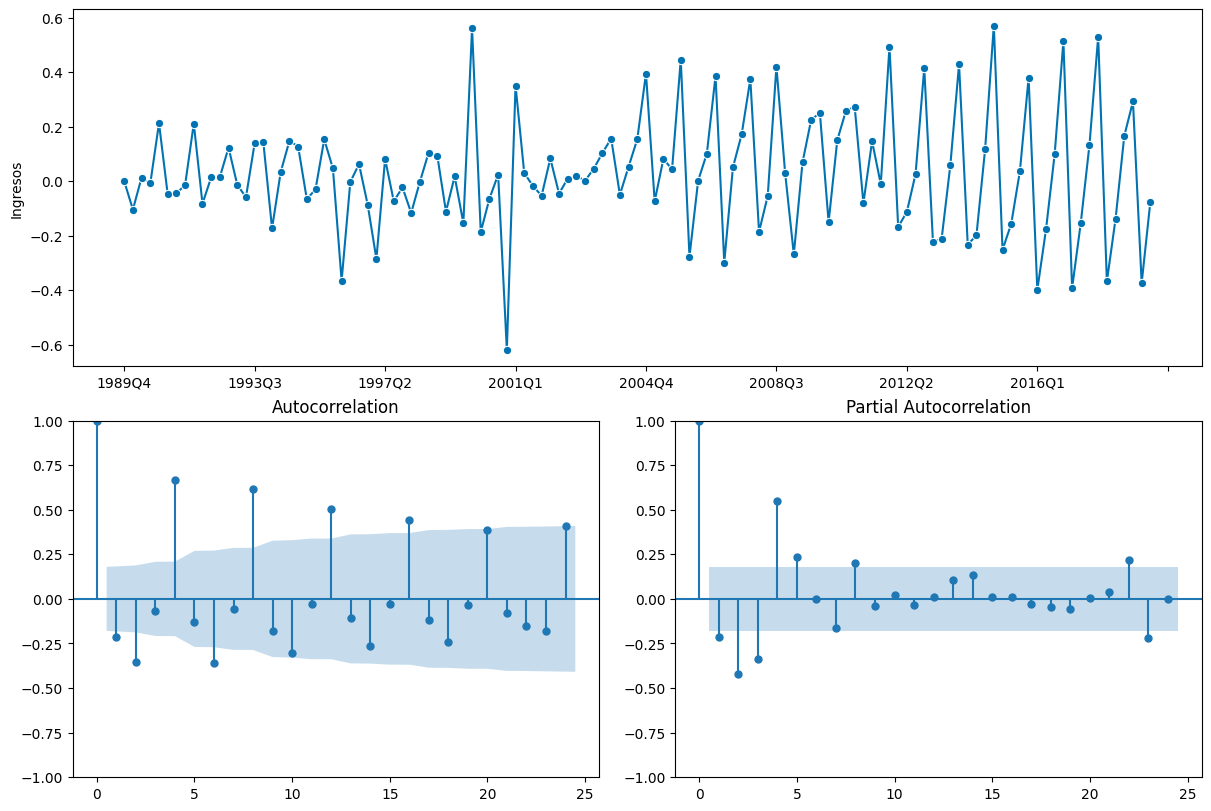

In [30]:
transf_diff=Differencer(lags=[1])
plot_correlations(transf_diff.fit_transform(y_train_log))

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Ingresos'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

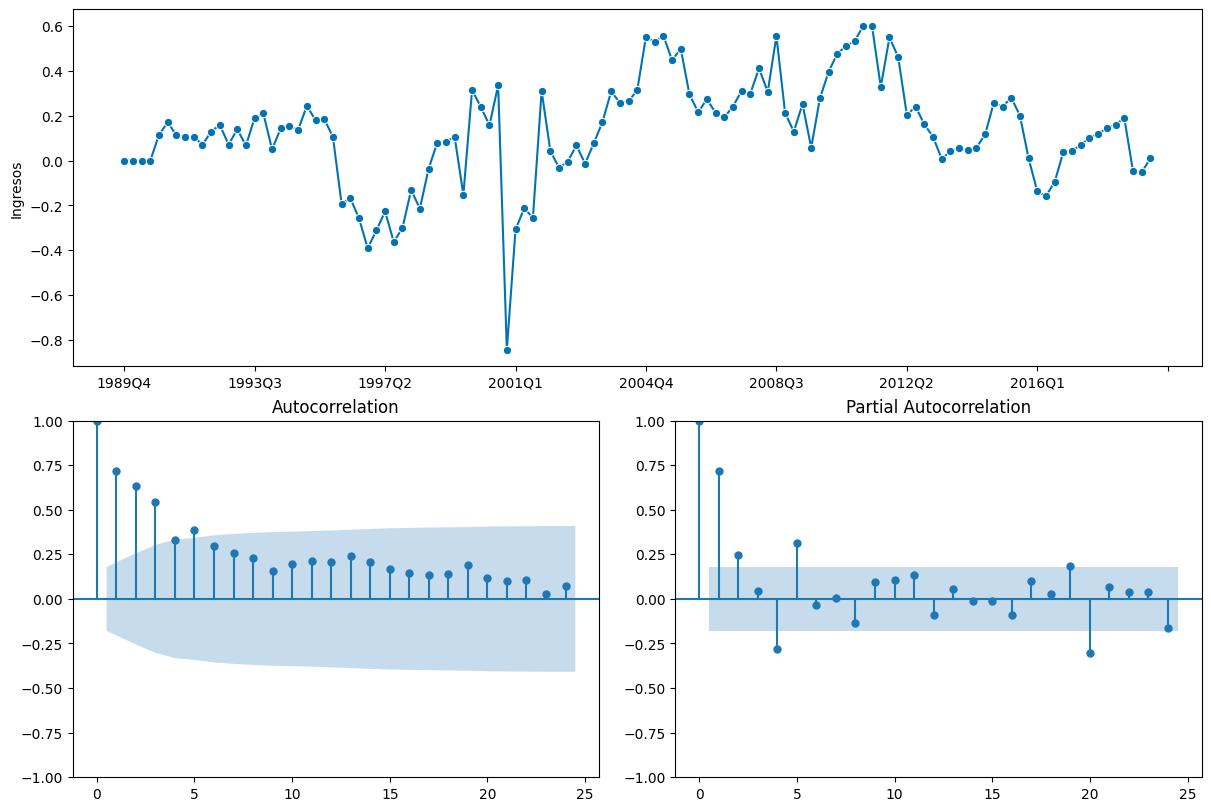

In [31]:
transf_diff=Differencer(lags=[4])
plot_correlations(transf_diff.fit_transform(y_train_log))

In [32]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA

In [33]:
arima_model = AutoARIMA(sp=4,suppress_warnings=True, trace=True)
arima_model.fit(y_train_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=-103.618, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-19.393, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-95.407, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-70.296, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-19.147, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=-89.132, Time=0.31 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=-99.312, Time=0.44 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=-100.777, Time=0.74 sec
 ARIMA(2,1,2)(1,0,2)[4] intercept   : AIC=-101.604, Time=0.55 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=-80.074, Time=0.16 sec
 ARIMA(2,1,2)(0,0,2)[4] intercept   : AIC=-93.801, Time=0.53 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=-100.112, Time=0.51 sec
 ARIMA(2,1,2)(2,0,2)[4] intercept   : AIC=-99.630, Time=0.69 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : AIC=-103.165, Time=0.29 sec
 ARIMA(2,1,1)(1,0,1)[4] intercept   : AIC=

AutoARIMA(sp=4, suppress_warnings=True, trace=True)

In [34]:
print(arima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                  58.362
Date:                           Mon, 09 Oct 2023   AIC                           -108.724
Time:                                   11:56:41   BIC                            -97.642
Sample:                               12-31-1989   HQIC                          -104.224
                                    - 06-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3363      0.089     -3.795      0.000      -0.510      -0.163
ar.S.L4        0.9156      0.062     14.822

In [35]:
y_pred_log = arima_model.predict(horizon)
np.exp(y_pred_log)

2019Q3    60183.674939
2019Q4    83757.822329
2020Q1    61526.178912
2020Q2    56094.939194
2020Q3    62284.140153
2020Q4    84295.715654
2021Q1    63555.016644
2021Q2    58398.541302
Freq: Q-DEC, Name: Ingresos, dtype: float64

In [36]:
# Forecast Accuracy
# MAPE
mean_absolute_percentage_error(y_test_log, y_pred_log)

0.013892973614064611

In [37]:
# Forecast Accuracy
# MAPE 
# Orignal Time Serie

mean_absolute_percentage_error(y_test, np.exp(y_pred_log))

0.13969639733058992

In [38]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test_log, y_pred_log)

0.20210986175416867

In [39]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test, np.exp(y_pred_log))

16022.608324659994

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

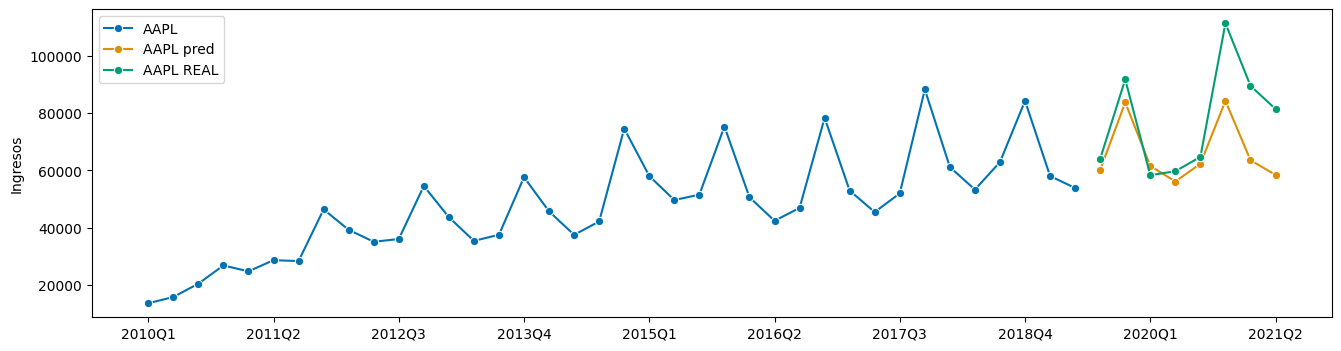

In [40]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(y_train['2010':], np.exp(y_pred_log),y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])

# Estimacion final

In [41]:
horizon = np.arange(10)
historic = df['Ingresos'].astype('float64').to_period('Q')

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

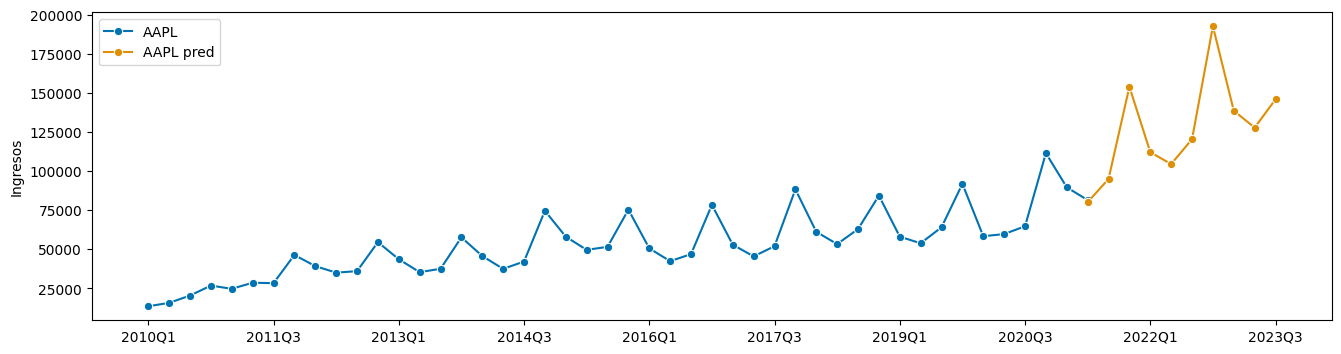

In [42]:
final_ets_model = AutoETS(auto=True, sp=4, n_jobs=-1)
final_ets_model.fit(historic)
ets_pred = final_ets_model.predict(horizon)
plot_series(historic['2010':], ets_pred, labels=["AAPL", "AAPL pred"])


In [43]:
historic_log = LogTransformer().fit_transform(historic)
final_arima_model = AutoARIMA(sp=4,suppress_warnings=True)
final_arima_model.fit(historic_log)
arima_pred = final_arima_model.predict(horizon)
np.exp(arima_pred)

2021Q2     79453.650075
2021Q3     89895.159267
2021Q4    134667.710973
2022Q1    102010.214502
2022Q2     95842.759213
2022Q3    105437.402726
2022Q4    153160.635738
2023Q1    118224.867498
2023Q2    111563.958591
2023Q3    121951.989827
Freq: Q-DEC, Name: Ingresos, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

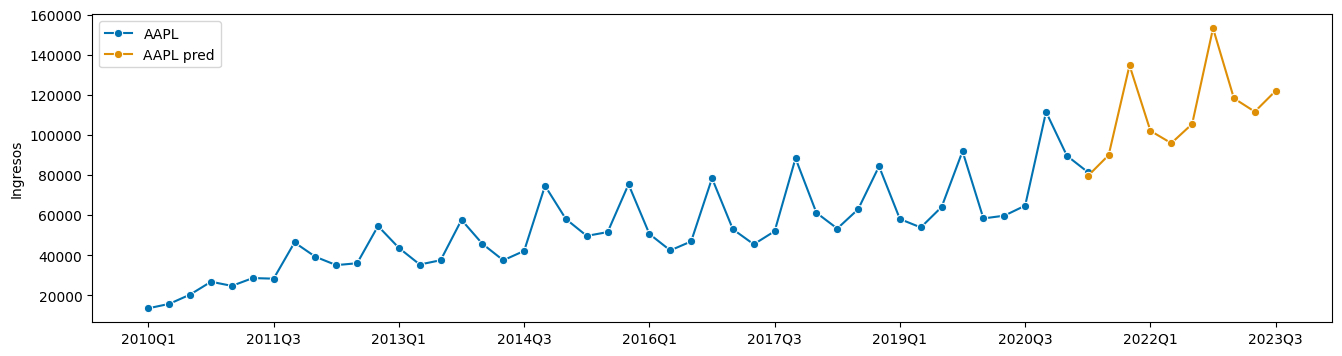

In [44]:
plot_series(historic['2010':], np.exp(arima_pred), labels=["AAPL", "AAPL pred"])

# Sección 3: Preguntas a resolver

### ¿Los ingresos de Apple son estacionarios? ¿En media? ¿En varianza?

##### - Los ingresos de Apple son no estacionarios, en media y varianza tambien son no estacionarios.

### ¿Cuál es su tendencia? ¿y su componente estacional?

##### - La tendencia es aditiva y la estacionalidad miltiplicativa.

### ¿Cuales son las ventas anuales de Apple?

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

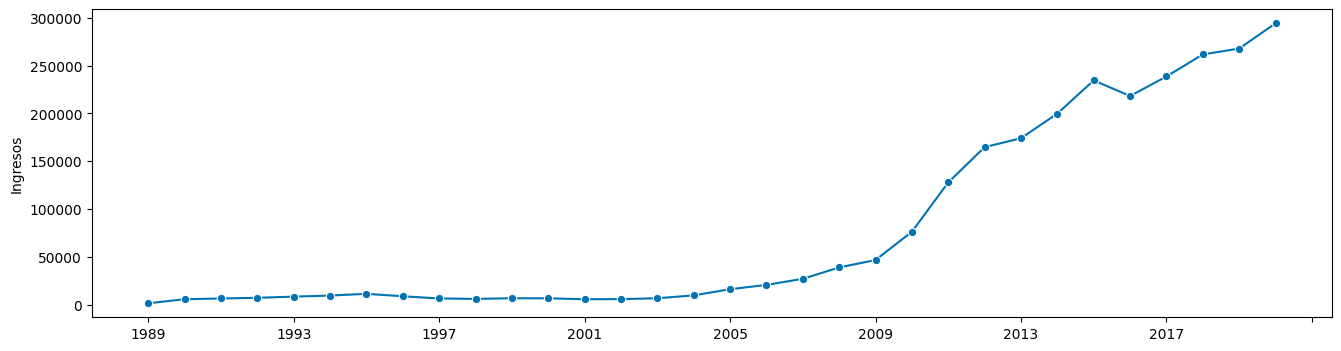

In [47]:
anual = df[:'2020']['Ingresos'].groupby(pd.Grouper(freq='Y')).sum()
anual.index = anual.index.year

plot_series(anual)

##### - Como podemos ver en el gráfico, en el último año Apple alcanza unas ventas record de unos 300000 millones de dolares

### ¿Cuales son los crecimientos anuales de los ingresos?

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

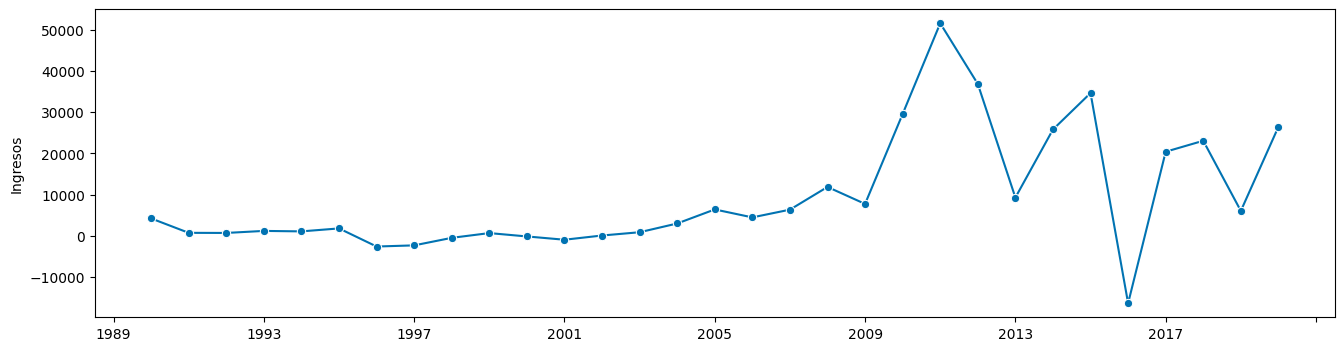

In [48]:
plot_series(anual.diff())

### ¿Qué modelo predice mejor?

##### - Los dos modelos son buenos pero el ARIMA es ligeramente mas preciso al medir errores porcentuales.

### ¿Existe efecto COVID? Cuantificar

##### - Mirando la serie temporal no parece que el COVID afectase en mucha medida los ingresos de Apple, ya que sigue con un incremento en ingresos parecido a lo pasado, incluso en epoca COVID.
##### - En el sentido de que si se hubiese predicho los valores del 2020 hace unos años, habrian sido muy parecidos tanto con COVID como sin COVID.

### ¿Cuales son las ventas acumuladas para el año 2021? ¿Y para el 2022?

In [65]:
print(f"Ventas 2021 por metodo ETS: {round((historic['2021':'2021'].sum() + ets_pred['2021':'2021'][1:].sum())/1000, 2)}",
    f"| Ventas 2021 por metodo Arima: {round((historic['2021':'2021'].sum() + np.exp(arima_pred)['2021':'2021'][1:].sum())/1000, 2)}",
    f"| Ventas 2022 por metodo ETS: {round(ets_pred['2022':'2022'].sum()/1000, 2)}",
    f"| Ventas 2022 por metodo Arima: {round(np.exp(arima_pred)['2022':'2022'].sum()/1000, 2)}")

Ventas 2021 por metodo ETS: 419.85 | Ventas 2021 por metodo Arima: 395.58 | Ventas 2022 por metodo ETS: 529.53 | Ventas 2022 por metodo Arima: 456.45


### ¿Son creíbles las predicciones del Barclays?

##### - Barclays predice unos ingresos en 2021 de 368.9 y en 2022 de 378.6. Comparando estos valores con los valores reales, la predicción para el 2021 parece ser creible, pero mirando 2022, las predicciones de Barclays se desvian de una mayor manera de la realidad, haciendo que no sea tan creible la predicción.